# Early Count Analysis

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Watermark</a></span></li><li><span><a href="#File-locations" data-toc-modified-id="File-locations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File locations</a></span></li><li><span><a href="#Plotting-stuff" data-toc-modified-id="Plotting-stuff-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting stuff</a></span></li></ul></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span><ul class="toc-item"><li><span><a href="#Recent-polling-data" data-toc-modified-id="Recent-polling-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Recent polling data</a></span></li><li><span><a href="#AEC-Enrolment-data" data-toc-modified-id="AEC-Enrolment-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>AEC Enrolment data</a></span></li><li><span><a href="#Latest-AEC-national-count-data" data-toc-modified-id="Latest-AEC-national-count-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Latest AEC national count data</a></span><ul class="toc-item"><li><span><a href="#First-preference-votes-nationally" data-toc-modified-id="First-preference-votes-nationally-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>First preference votes nationally</a></span></li><li><span><a href="#First-preferences-by-Division" data-toc-modified-id="First-preferences-by-Division-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>First preferences by Division</a></span></li><li><span><a href="#First-preference-by-state" data-toc-modified-id="First-preference-by-state-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>First preference by state</a></span></li><li><span><a href="#Two-party-preferred-votes-by-state" data-toc-modified-id="Two-party-preferred-votes-by-state-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Two party preferred votes by state</a></span></li><li><span><a href="#Two-Party-Preferred-by-Division" data-toc-modified-id="Two-Party-Preferred-by-Division-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Two Party Preferred by Division</a></span></li><li><span><a href="#Two-candidate-preferred-by-Division" data-toc-modified-id="Two-candidate-preferred-by-Division-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Two candidate preferred by Division</a></span></li></ul></li></ul></li><li><span><a href="#Data-consistency-checks" data-toc-modified-id="Data-consistency-checks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data consistency checks</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#Explore-primary-polls-vs-election-result" data-toc-modified-id="Explore-primary-polls-vs-election-result-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Explore primary polls vs election result</a></span></li><li><span><a href="#Explore-2pp-Polls-vs-Election-Result" data-toc-modified-id="Explore-2pp-Polls-vs-Election-Result-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Explore 2pp Polls vs Election Result</a></span></li><li><span><a href="#State-2pp-swings" data-toc-modified-id="State-2pp-swings-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>State 2pp swings</a></span></li><li><span><a href="#State-primary-first-preference-swings" data-toc-modified-id="State-primary-first-preference-swings-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>State primary first preference swings</a></span></li><li><span><a href="#Divisional-2pp-swings" data-toc-modified-id="Divisional-2pp-swings-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Divisional 2pp swings</a></span></li><li><span><a href="#Green-TCP-swings" data-toc-modified-id="Green-TCP-swings-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Green TCP swings</a></span></li><li><span><a href="#Traditional-TCP-swings" data-toc-modified-id="Traditional-TCP-swings-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Traditional TCP swings</a></span></li></ul></li><li><span><a href="#Seat-allocations" data-toc-modified-id="Seat-allocations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Seat allocations</a></span><ul class="toc-item"><li><span><a href="#Key-thresholds" data-toc-modified-id="Key-thresholds-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Key thresholds</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#First-preferences" data-toc-modified-id="First-preferences-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>First preferences</a></span></li><li><span><a href="#TCP" data-toc-modified-id="TCP-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>TCP</a></span></li><li><span><a href="#House-outcome-and-closer-seats" data-toc-modified-id="House-outcome-and-closer-seats-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>House outcome and closer seats</a></span></li></ul></li><li><span><a href="#The-End" data-toc-modified-id="The-End-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python setup

### Imports

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# system imports
from pathlib import Path
import itertools
import numbers
import math
from typing import Any, Union, Iterable, Optional

# local imports
import common

### Watermark

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed May 25 2022 17:08:30

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

numpy     : 1.22.4
matplotlib: 3.5.2
pandas    : 1.4.2

Watermark: 2.3.0



### File locations

In [3]:
# path to the model data 
PUBLIC_DATA_DIR = '../data/'
Path(PUBLIC_DATA_DIR).mkdir(parents=True, exist_ok=True)

PRIVATE_DATA_DIR = '../historical-data/'
Path(PRIVATE_DATA_DIR).mkdir(parents=True, exist_ok=True)

CHARTS_DIR = '../charts/'
Path(CHARTS_DIR).mkdir(parents=True, exist_ok=True)

### Plotting stuff

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

## Get data

### Recent polling data

In [5]:
FINAL_POLLING_PERIOD = 4 # days - polls in last few days

def get_last_polls():
    current_polls = f'{PUBLIC_DATA_DIR}primary_vote.csv' 
    polls = pd.read_csv(current_polls, parse_dates=['Mean Date'], index_col=0)
    final_date = polls['Mean Date'].max()
    start_date = final_date - pd.Timedelta(days=FINAL_POLLING_PERIOD)
    retain_polls_mask = ((polls['Mean Date'] >= start_date) 
                         & (polls['Mean Date'] <= final_date))
    return polls[retain_polls_mask]

In [6]:
polls = get_last_polls()
PRIMARIES = {
    'Primary vote L/NP': 'Coalition',
    'Primary vote ALP': 'Labor',
    'Primary vote GRN': 'Green',
    'Primary vote ONP': 'One Nation',
    'Primary vote UAP': 'UAP',
    'Primary vote OTH': 'Other',
}
primary_polls = polls.rename(columns=PRIMARIES)
primary_polls_final_mean = (
    # let's do a sample-size weighted average
    (primary_polls[PRIMARIES.values()]
     .mul(primary_polls['Sample size'], axis=0)).sum() 
    / primary_polls['Sample size'].sum()
)
primary_polls_final_mean

Coalition     35.350493
Labor         34.943326
Green         12.438486
One Nation     4.966181
UAP            2.974027
Other          9.327487
dtype: float64

### AEC Enrolment data

In [7]:
enrolmentByDiv = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'GeneralEnrolmentByDivisionDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
enrolmentByDiv.index = enrolmentByDiv['DivisionNm']

enrolment_div = enrolmentByDiv.Enrolment
enrolment_state = enrolmentByDiv.groupby('StateAb').sum().Enrolment

### Latest AEC national count data

#### First preference votes nationally

In [8]:
houseFirstPrefsByParty = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseFirstPrefsByPartyDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
houseFirstPrefsByParty = houseFirstPrefsByParty.set_index(['PartyAb'], drop=True)
houseFirstPrefsByParty.columns

Index(['PartyNm', 'OrderOfAppearance', 'Contested', 'Nominations', 'Elected',
       'OrdinaryVotes', 'OrdinaryPercentage', 'AbsentVotes',
       'AbsentPercentage', 'ProvisionalVotes', 'ProvisionalPercentage',
       'PrePollVotes', 'PrePollPercentage', 'PostalVotes', 'PostalPercentage',
       'TotalVotes', 'TotalPercentage', 'TotalSwing'],
      dtype='object')

In [9]:
# Party groupings
groups = {
    'Coalition': ['LP', 'LNP', 'NP', 'CLP'],
    'Labor': ['ALP'],
    'Green': ['GRN'],
    'One Nation': ['ON'],
    'UAP': ['UAPP'],
}
groups['Other'] = (
    list(set(houseFirstPrefsByParty.index.to_list()) 
         - set(itertools.chain.from_iterable(groups.values())))
)

In [10]:
def get_group_totals(data):
    total_votes = data['TotalVotes'].sum()
    primary_tally = {}
    for label, group in groups.items():
        both = list(set(group).intersection(set(data.index)))
        primary_tally[label] = (
            data
            .loc[both, 'TotalVotes']
            .sum() 
            / total_votes * 100
        )
    return pd.Series(primary_tally)

In [11]:
# current state of primary votes
primary_tally = get_group_totals(houseFirstPrefsByParty)
primary_tally

Coalition     36.005186
Labor         32.807826
Green         11.759212
One Nation     4.859277
UAP            4.110447
Other         10.458052
dtype: float64

#### First preferences by Division

In [12]:
houseFirstPrefsByCandidate = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseFirstPrefsByCandidateByVoteTypeDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
print(houseFirstPrefsByCandidate.TotalVotes.sum())
print(houseFirstPrefsByCandidate.columns)
fp_by_div = pd.pivot_table(houseFirstPrefsByCandidate, index='DivisionNm', 
                           columns='PartyAb', 
                           values='TotalVotes', aggfunc=pd.Series.sum)
fp_by_div.shape

12931020
Index(['StateAb', 'DivisionID', 'DivisionNm', 'CandidateID', 'Surname',
       'GivenNm', 'BallotPosition', 'Elected', 'HistoricElected', 'PartyAb',
       'PartyNm', 'OrdinaryVotes', 'AbsentVotes', 'ProvisionalVotes',
       'PrePollVotes', 'PostalVotes', 'TotalVotes', 'Swing'],
      dtype='object')


(151, 36)

In [13]:
assert not fp_by_div.columns.has_duplicates

In [14]:
fp_by_div.iloc[0:10, 0:20]

PartyAb,AJP,ALP,ASP,AUC,AUD,AUP,AUVA,CEC,CLP,CYA,DHJP,DPDA,GAP,GRN,HMP,IAP,IMO,IND,JLN,KAP
DivisionNm,,,,,,,,,,,,,,,,,,,,
Adelaide,NaN,35099.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,636.0,NaN,NaN,NaN,17714.0,NaN,NaN,NaN,NaN,NaN,NaN
Aston,NaN,26836.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9554.0,NaN,NaN,NaN,NaN,NaN,NaN
Ballarat,NaN,35188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,554.0,NaN,NaN,NaN,11219.0,NaN,NaN,NaN,1551.0,NaN,NaN
Banks,NaN,28981.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6871.0,NaN,NaN,NaN,NaN,NaN,NaN
Barker,NaN,18930.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,660.0,NaN,NaN,NaN,6522.0,NaN,NaN,NaN,4427.0,NaN,NaN
Barton,NaN,40046.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9333.0,NaN,NaN,NaN,NaN,NaN,NaN
Bass,791.0,16415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6125.0,NaN,NaN,NaN,2830.0,3719.0,NaN
Bean,NaN,37567.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12872.0,NaN,NaN,NaN,7274.0,NaN,NaN
Bendigo,NaN,37887.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11784.0,NaN,NaN,NaN,3738.0,NaN,NaN


In [15]:
# the least counted
fp_count_pct = fp_by_div.sum(axis=1) / enrolment_div * 100
fp_count_pct.sort_values().head()

DivisionNm
Lingiari     56.618501
Durack       59.095126
Melbourne    59.690512
Perth        62.421467
Cowan        62.528413
dtype: float64

In [16]:
# the most counted
fp_count_pct.sort_values().tail()

DivisionNm
Mackellar    80.555655
Bean         81.242641
Gilmore      81.782470
Page         82.580645
Calare       83.055016
dtype: float64

In [17]:
fp_vote_pct = (fp_by_div.div(fp_by_div.sum(axis=1), axis=0) * 100).round(2)
fp_vote_pct.iloc[0:10, 0:20]

PartyAb,AJP,ALP,ASP,AUC,AUD,AUP,AUVA,CEC,CLP,CYA,DHJP,DPDA,GAP,GRN,HMP,IAP,IMO,IND,JLN,KAP
DivisionNm,,,,,,,,,,,,,,,,,,,,
Adelaide,NaN,40.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.73,NaN,NaN,NaN,20.34,NaN,NaN,NaN,NaN,NaN,NaN
Aston,NaN,32.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.68,NaN,NaN,NaN,NaN,NaN,NaN
Ballarat,NaN,44.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.71,NaN,NaN,NaN,14.34,NaN,NaN,NaN,1.98,NaN,NaN
Banks,NaN,35.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.35,NaN,NaN,NaN,NaN,NaN,NaN
Barker,NaN,20.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.73,NaN,NaN,NaN,7.17,NaN,NaN,NaN,4.87,NaN,NaN
Barton,NaN,51.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.92,NaN,NaN,NaN,NaN,NaN,NaN
Bass,1.4,29.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.86,NaN,NaN,NaN,5.02,6.59,NaN
Bean,NaN,42.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.46,NaN,NaN,NaN,8.17,NaN,NaN
Bendigo,NaN,43.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.50,NaN,NaN,NaN,4.28,NaN,NaN


#### First preference by state 

In [18]:
houseFirstPrefsByStateByParty2022 = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseFirstPrefsByStateByPartyDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseFirstPrefsByStateByParty2022 = houseFirstPrefsByStateByParty2022.set_index(['PartyAb'], drop=True)

houseFirstPrefsByStateByParty2019 = (
    pd.read_csv('https://results.aec.gov.au/24310/Website/'
                'Downloads/HouseFirstPrefsByStateByPartyDownload-24310.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseFirstPrefsByStateByParty2019 = houseFirstPrefsByStateByParty2019.set_index(['PartyAb'], drop=True)

houseFirstPrefsByStateByParty2022

,StateAb,PartyNm,OrderOfAppearance,Contested,Nominations,Elected,OrdinaryVotes,OrdinaryPercentage,AbsentVotes,AbsentPercentage,ProvisionalVotes,ProvisionalPercentage,DeclarationPrePollVotes,DeclarationPrePollPercentage,PostalVotes,PostalPercentage,TotalVotes,TotalPercentage,TotalSwing
PartyAb,,,,,,,,,,,,,,,,,,,
LP,NSW,Liberal,1,38,38,0,1061615,27.74,0,0.0,0,0.0,0,0.0,78942,34.84,1140557,28.14,-4.65
NP,NSW,The Nationals,2,9,9,0,339846,8.88,0,0.0,0,0.0,0,0.0,17626,7.78,357472,8.82,-0.94
ALP,NSW,Australian Labor Party,3,47,47,0,1281763,33.49,0,0.0,0,0.0,0,0.0,74415,32.85,1356178,33.45,-1.11
UAPP,NSW,United Australia Party,4,47,47,0,152251,3.98,0,0.0,0,0.0,0,0.0,5554,2.45,157805,3.89,0.51
IND,NSW,Independent,5,27,37,0,297074,7.76,0,0.0,0,0.0,0,0.0,16301,7.20,313375,7.73,3.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDP,NT,Liberal Democratic Party,4,2,2,0,6389,7.29,0,0.0,0,0.0,0,0.0,327,9.08,6716,7.36,7.36
ON,NT,Pauline Hanson's One Nation,5,2,2,0,4503,5.14,0,0.0,0,0.0,0,0.0,219,6.08,4722,5.18,5.18
UAPP,NT,United Australia Party,6,2,2,0,3890,4.44,0,0.0,0,0.0,0,0.0,96,2.67,3986,4.37,1.52


#### Two party preferred votes by state

In [19]:
houseTppByState = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseTppByStateDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)

# State name as index - add percent counted to the data
houseTppByState.index = houseTppByState['StateAb']
houseTppByState['Enrolment'] = enrolment_state
houseTppByState['Counted%'] =  houseTppByState['TotalVotes'] / houseTppByState['Enrolment']* 100.0
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1560120,48.62,1648557,51.38,3208677,-3.16,5472469,58.633078
VIC,VIC,Victoria,1105066,45.33,1332594,54.67,2437660,-1.53,4344208,56.112875
QLD,QLD,Queensland,1107245,54.51,924140,45.49,2031385,-3.93,3503609,57.979786
WA,WA,Western Australia,486665,44.39,609665,55.61,1096330,-11.16,1773969,61.800967
SA,SA,South Australia,329530,44.60,409347,55.40,738877,-4.69,1272047,58.085668
TAS,TAS,Tasmania,116021,48.67,122353,51.33,238374,4.63,402331,59.248231
ACT,ACT,Australian Capital Territory,60252,35.50,109480,64.50,169732,-2.89,314329,53.998199
NT,NT,Northern Territory,40474,44.37,50741,55.63,91215,-1.43,145938,62.502570


In [20]:
labor_tpp_election = (
    houseTppByState['Australian Labor Party Votes'].sum()
    / (houseTppByState['Australian Labor Party Votes'].sum()
       + houseTppByState['Liberal/National Coalition Votes'].sum())
    * 100
)
labor_tpp_election

52.00506379684886

#### Two Party Preferred by Division

In [21]:
houseTppByDivision = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseTppByDivisionDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseTppByDivision.index = houseTppByDivision['DivisionNm']
houseTppByDivision['Enrolment'] = enrolment_div
houseTppByDivision['Counted%'] =  houseTppByDivision['TotalVotes'] / houseTppByDivision['Enrolment']* 100.0

# IMPORTANT -- How many electorates are missing TPP vote data
houseTppByDivision[(houseTppByDivision['Counted%'] == 0.0)]

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
DivisionNm,,,,,,,,,,,,
Bradfield,Bradfield,108,NSW,NaN,0,0.0,0,0.0,0,-66.56,108573,0.0
Calare,Calare,109,NSW,NaN,0,0.0,0,0.0,0,-63.29,121564,0.0
Canberra,Canberra,101,ACT,NaN,0,0.0,0,0.0,0,-32.92,102196,0.0
Clark,Clark,319,TAS,NaN,0,0.0,0,0.0,0,-33.83,74797,0.0
Cooper,Cooper,320,VIC,NaN,0,0.0,0,0.0,0,-23.79,108730,0.0
Cowper,Cowper,113,NSW,NaN,0,0.0,0,0.0,0,-61.88,129887,0.0
Curtin,Curtin,238,WA,NaN,0,0.0,0,0.0,0,-63.95,119397,0.0
Fowler,Fowler,119,NSW,NaN,0,0.0,0,0.0,0,-36.01,108517,0.0
Goldstein,Goldstein,214,VIC,NaN,0,0.0,0,0.0,0,-57.79,109773,0.0


In [22]:
# make a more useful index
houseTppByDivision.index = (
    houseTppByDivision['DivisionNm'] + ' (' + 
    houseTppByDivision['StateAb'] + ')'
)
houseTppByDivision.head()

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
Adelaide (SA),Adelaide,179,SA,NaN,33009,37.90,54092,62.10,87101,-3.92,130151,66.923036
Aston (VIC),Aston,197,VIC,NaN,43469,53.16,38303,46.84,81772,-6.97,109826,74.455958
Ballarat (VIC),Ballarat,198,VIC,NaN,28907,36.96,49303,63.04,78210,-2.81,110704,70.647854
Banks (NSW),Banks,103,NSW,NaN,44211,53.74,38053,46.26,82264,-2.52,107786,76.321600
Barker (SA),Barker,180,SA,NaN,59312,65.24,31601,34.76,90913,-3.70,123518,73.603038


#### Two candidate preferred by Division

In [23]:
houseTcp = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseTcpByCandidateByVoteTypeDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseTcp.head()

,StateAb,DivisionID,DivisionNm,CandidateID,Surname,GivenNm,BallotPosition,Elected,HistoricElected,PartyAb,PartyNm,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,Swing
0,ACT,318,Bean,36231,SMITH,David,3,N,Y,ALP,Australian Labor Party,53888,0,0,0,2339,56227,5.65
1,ACT,318,Bean,37198,HIATT,Jane,6,N,N,LP,Liberal,31226,0,0,0,1554,32780,-5.65
2,ACT,101,Canberra,36241,HOLLO,Tim,5,N,N,GRN,The Greens,23248,0,0,0,1953,25201,37.19
3,ACT,101,Canberra,36228,PAYNE,Alicia,6,N,Y,ALP,Australian Labor Party,38689,0,0,0,3880,42569,62.81
4,ACT,102,Fenner,36234,LEIGH,Andrew,1,N,Y,ALP,Australian Labor Party,50931,0,0,0,2322,53253,5.41


In [24]:
COALITION = ['LNP', 'LP', 'NP', 'CLP']
tcp_swings = pd.pivot_table(houseTcp, index='DivisionNm', 
                            values='Swing', columns='PartyAb')

# check we do not have any Coalition v Coalition contests
assert (tcp_swings[COALITION].notna().sum(axis=1) <= 1).any()

In [25]:
tcp_swings['Coalition'] = (
    tcp_swings[COALITION].sum(axis=1)
    .where(tcp_swings[COALITION].notna().any(axis=1), other=np.nan)
)
tcp_swings = tcp_swings.drop(columns=COALITION)
tcp_swings.head()

PartyAb,ALP,GRN,IND,KAP,XEN,Coalition
DivisionNm,,,,,,
Adelaide,3.92,NaN,NaN,NaN,NaN,-3.92
Aston,6.97,NaN,NaN,NaN,NaN,-6.97
Ballarat,2.81,NaN,NaN,NaN,NaN,-2.81
Banks,2.52,NaN,NaN,NaN,NaN,-2.52
Barker,3.70,NaN,NaN,NaN,NaN,-3.70


In [26]:
raw_tcp_votes = pd.pivot_table(houseTcp, index='DivisionNm', 
                            values='TotalVotes', columns='PartyAb')

# Check for Coalition v Coalition contests
assert (raw_tcp_votes[COALITION].notna().sum(axis=1) <= 1).any()

cooked_tcp_votes = raw_tcp_votes.copy()
cooked_tcp_votes['Coalition'] = (
    cooked_tcp_votes[COALITION].sum(axis=1)
    .where(cooked_tcp_votes[COALITION].notna().any(axis=1), other=np.nan)
)
cooked_tcp_votes = cooked_tcp_votes.drop(columns=COALITION)
cooked_tcp_counted = cooked_tcp_votes.sum(axis=1) / enrolment_div * 100 

In [27]:
# convert to per cents
raw_pct_tcp_votes = raw_tcp_votes.div(raw_tcp_votes.sum(axis=1), axis=0) * 100
cooked_pct_tcp_votes = cooked_tcp_votes.div(cooked_tcp_votes.sum(axis=1), axis=0) * 100
cooked_pct_tcp_votes.head()

PartyAb,ALP,GRN,IND,KAP,XEN,Coalition
DivisionNm,,,,,,
Adelaide,62.102617,NaN,NaN,NaN,NaN,37.897383
Aston,46.841217,NaN,NaN,NaN,NaN,53.158783
Ballarat,63.039253,NaN,NaN,NaN,NaN,36.960747
Banks,46.257172,NaN,NaN,NaN,NaN,53.742828
Barker,34.759605,NaN,NaN,NaN,NaN,65.240395


## Data consistency checks

In [28]:
# All first preferences
assert houseFirstPrefsByParty.TotalVotes.sum() == fp_by_div.sum().sum()
houseFirstPrefsByParty.TotalVotes.sum()

12278348

In [29]:
# TPP
assert houseTppByState.TotalVotes.sum() == houseTppByDivision.TotalVotes.sum()
houseTppByDivision.TotalVotes.sum()

10012250

In [30]:
# TCP


## Plots

### Explore primary polls vs election result

In [31]:
colours = {
    'Coalition': 'blue',
    'Labor': '#dd0000',
    'Green': 'green',
    'One Nation': 'darkorange',
    'UAP': 'gold',
    'Other': 'darkorchid',
}

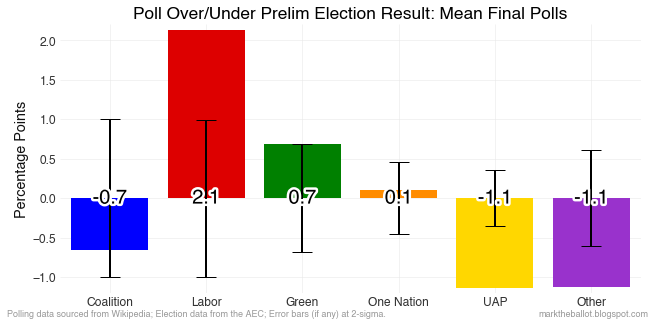

In [32]:
def difference_plot(polls, election, sample_size=None, **kwargs):
    
    SIGMA = 2
    compar = polls - election
    colors = kwargs['colors'] if 'colors' in kwargs else 'darkcyan'
    if type(colors) is str:
        colors = pd.Series([colors]*len(compar), index=compar.index)

    fig, ax = common.initiate_plot()
    for x, y in compar.iteritems():
        ax.bar(x, y, color=colors[x])
        text = ax.text(x, 0, f'{y:0.1f}', ha='center', va='center',
            fontsize=20)
        text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])
        
        if sample_size is not None:
            ss = sample_size if isinstance(sample_size, numbers.Number) else sample_size[x]
            p = polls[x] / 100
            z = np.sqrt((p*(1-p))/ss) * 100
            ax.errorbar(x, 0, yerr=SIGMA*z, ecolor='black', capsize=10)
        
    title = kwargs['title'] if 'title' in kwargs else None
    common.plot_finalise(
        ax, 
        title=title, 
        ylabel='Percentage Points', 
        lfooter='Polling data sourced from Wikipedia; '
                'Election data from the AEC; '
                f'Error bars (if any) at {SIGMA}-sigma.', 
    )

difference_plot(primary_polls_final_mean, primary_tally, 
                primary_polls['Sample size'].sum(), 
                colors=colours,
                title='Poll Over/Under Prelim Election Result: Mean Final Polls')

In [33]:
primary_polls.columns

Index(['Coalition', 'Labor', 'Green', 'One Nation', 'UAP', 'Other', 'Date',
       'Mean Date', 'Brand', 'Interview mode', 'Sample size',
       'Calculated 2pp L/NP', 'Calculated 2pp ALP'],
      dtype='object')

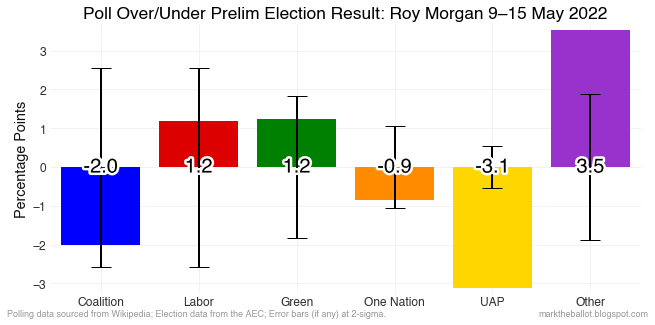

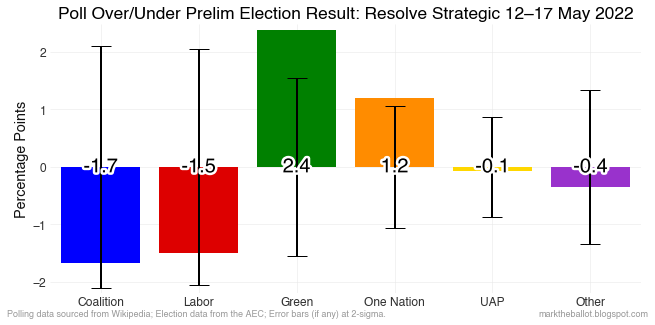

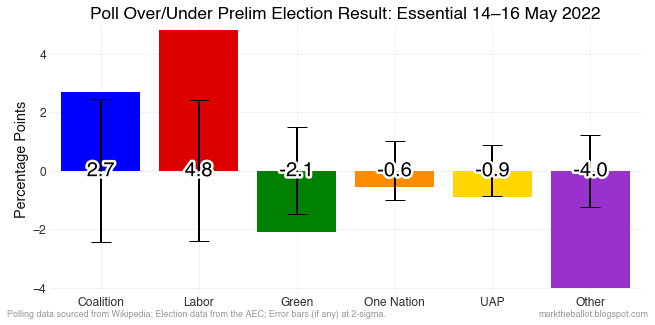

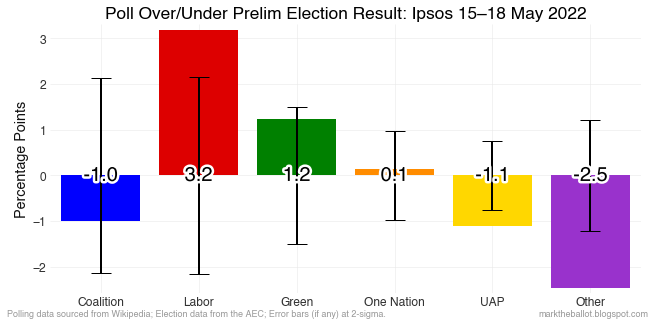

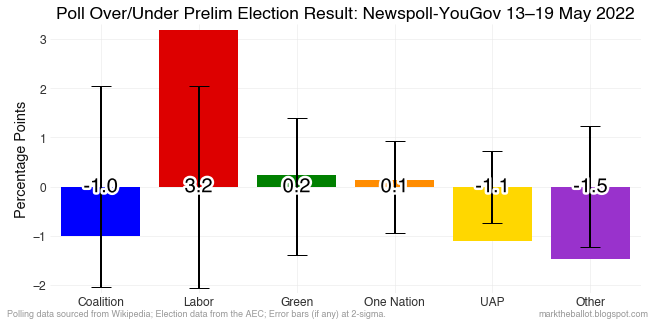

In [34]:
primary_polls.index = primary_polls['Brand'] + ' ' + primary_polls['Date']
for name, poll in primary_polls.iterrows():
    title = f'Poll Over/Under Prelim Election Result: {name}'
    sample_size = poll['Sample size']
    difference_plot(poll[PRIMARIES.values()], primary_tally, 
                    sample_size=sample_size, 
                    colors=colours,
                    title=title)

### Explore 2pp Polls vs Election Result

In [35]:
MFP = 'Mean final polls'
tpp = primary_polls.copy()
tpp.index =  tpp['Brand'] + '\n' +  tpp['Date']
addition = pd.Series([np.nan]*len(tpp.columns), index=tpp.columns, name=MFP)
addition['Sample size'] = tpp['Sample size'].sum()
addition['Calculated 2pp ALP'] = (
    # let's do a weitherd mean
    (tpp['Calculated 2pp ALP'] * tpp['Sample size']).sum()
    / tpp['Sample size'].sum()
)
addition = pd.DataFrame(addition).T
tpp = pd.concat([tpp, addition])

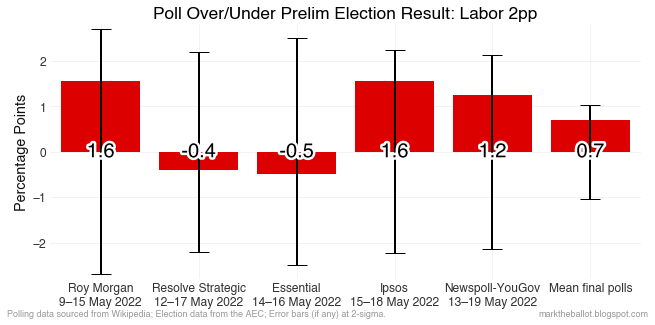

In [36]:
title = 'Poll Over/Under Prelim Election Result: Labor 2pp'
sample_size = poll['Sample size']
difference_plot(tpp['Calculated 2pp ALP'], labor_tpp_election, 
                    sample_size=tpp['Sample size'], 
                    colors='#dd0000',
                    title=title)


### State 2pp swings

In [37]:
def set_up_swing_chart(data:pd.Series):
    
    assert isinstance(data, pd.Series)
    fig, ax = common.initiate_plot()
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)

    rightax = ax.twinx()
    ax.get_shared_y_axes().join(ax, rightax)
    rightax.grid(False)
    
    sorted_data = data.sort_values()
    labels = sorted_data.index
    sorted_data = sorted_data.reset_index(drop=True)
    
    ylims = sorted_data.index.min() - 0.5, sorted_data.index.max() + 0.5
    ax.set_ylim(ylims)
    rightax.set_ylim(ylims)
   
    return ax, rightax, sorted_data, labels


def finalise_swing_chart(ax, rightax, data, labels):

    ax.yaxis.set_ticks_position('left')
    rightax.yaxis.set_ticks_position('right')
    ax.spines['left'].set_position(('data',0),)
    ax.spines['left'].set_color('#999999')
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(1)
    rightax.spines['right'].set_position(('data',0))

    ax.set_yticks(data.index)
    rightax.set_yticks(data.index)

    ax.set_yticklabels(labels.where(data >= 0, other=''))
    rightax.set_yticklabels(labels.where(data < 0, other=''))


In [38]:
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1560120,48.62,1648557,51.38,3208677,-3.16,5472469,58.633078
VIC,VIC,Victoria,1105066,45.33,1332594,54.67,2437660,-1.53,4344208,56.112875
QLD,QLD,Queensland,1107245,54.51,924140,45.49,2031385,-3.93,3503609,57.979786
WA,WA,Western Australia,486665,44.39,609665,55.61,1096330,-11.16,1773969,61.800967
SA,SA,South Australia,329530,44.60,409347,55.40,738877,-4.69,1272047,58.085668
TAS,TAS,Tasmania,116021,48.67,122353,51.33,238374,4.63,402331,59.248231
ACT,ACT,Australian Capital Territory,60252,35.50,109480,64.50,169732,-2.89,314329,53.998199
NT,NT,Northern Territory,40474,44.37,50741,55.63,91215,-1.43,145938,62.502570


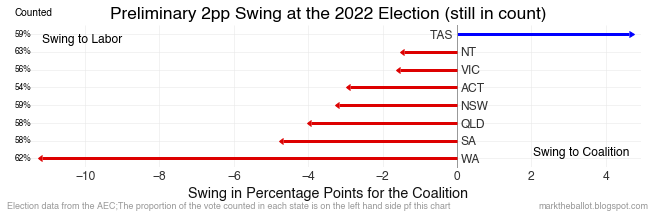

In [39]:
# marshall our data
data = houseTppByState['Swing']

# plot our data
ax, rightax, data, labels = set_up_swing_chart(houseTppByState['Swing'])
ax.figure.set_size_inches(9, 3)
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')
        
finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each state
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{houseTppByState.at[label, "Counted%"]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

# annotate axes
ax.text(data.min(), data.index.max(), 'Swing to Labor',
        ha='left', va='top', fontsize='large')
ax.text(data.max(), data.index.min(), 'Swing to Coalition',
        ha='right', va='bottom', fontsize='large')

common.plot_finalise(
    ax, 
    title='Preliminary 2pp Swing at the 2022 Election (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points for the Coalition', 
    lfooter='Election data from the AEC;'
            'The proportion of the vote counted in each state is on the left hand side pf this chart', 
)

### State primary first preference swings

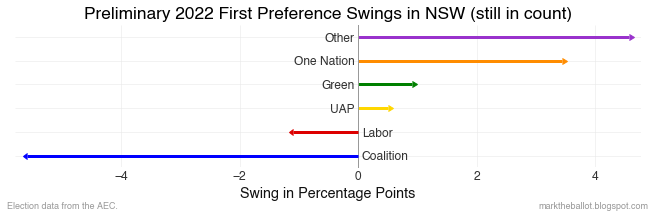

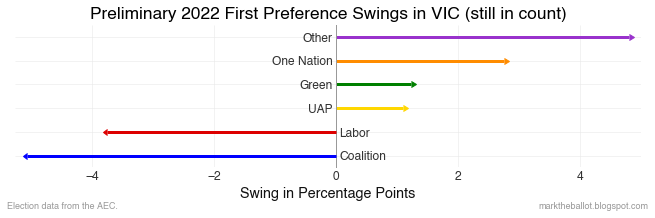

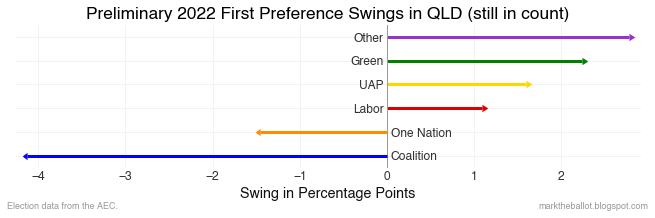

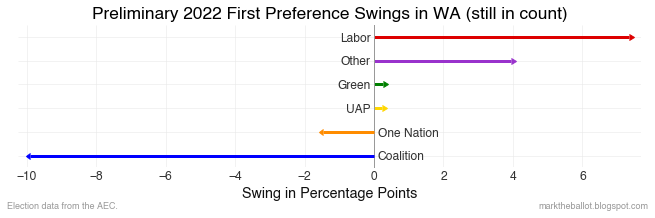

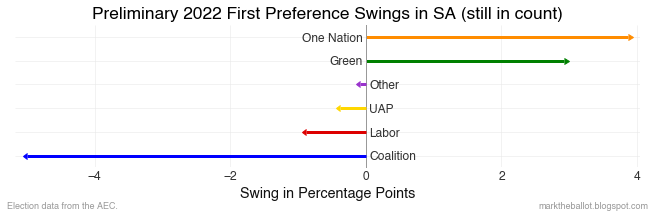

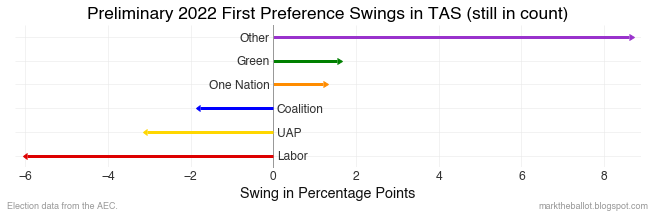

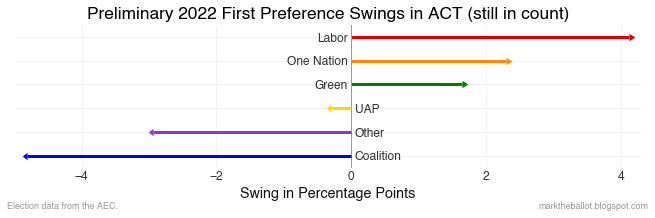

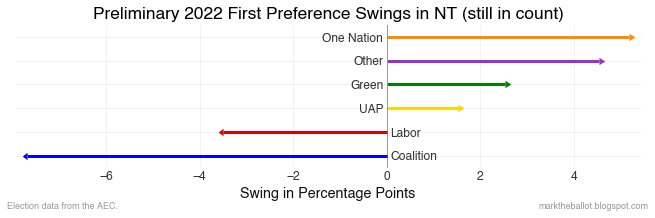

In [40]:
d22 = houseFirstPrefsByStateByParty2022
d19 = houseFirstPrefsByStateByParty2019

combined = {}
for state in d22['StateAb'].unique():

    # data marshalling 
    state2022 = d22[d22['StateAb'] == state].copy()
    state2019 = d19[d19['StateAb'] == state].copy()
    grouped2022 = get_group_totals(state2022)
    grouped2019 = get_group_totals(state2019)
    swings2022 = (grouped2022 - grouped2019).sort_values()
    for group, value in swings2022.iteritems():
        if group in combined:
            combined[group] = combined[group] | {state: value} # Python 3.10 feature
        else:
            combined[group] = {state: value}
    
    # plot
    ax, rightax, data, labels = set_up_swing_chart(swings2022)
    ax.figure.set_size_inches(9, 3)


    for x, y, l in zip(data, data.index, labels):
        ecolor = colours[l]
        if x >= 0:
            ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=ecolor)
        else:
            rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=ecolor)

    finalise_swing_chart(ax, rightax, data, labels)

    common.plot_finalise(
        ax, 
        title=f'Preliminary 2022 First Preference Swings in {state} (still in count)',
        ylabel=None,
        xlabel='Swing in Percentage Points', 
        lfooter='Election data from the AEC.', 
    )    

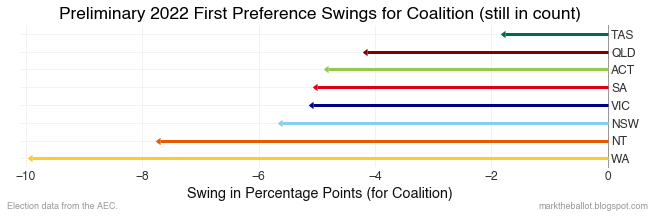

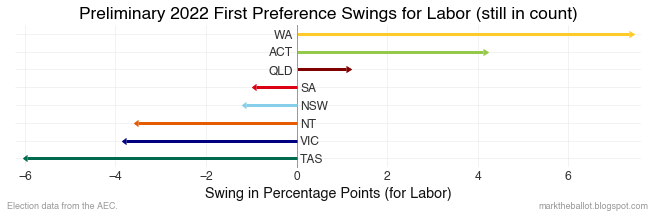

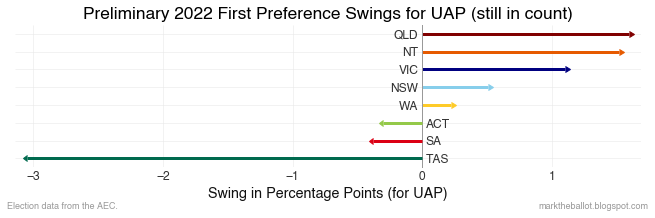

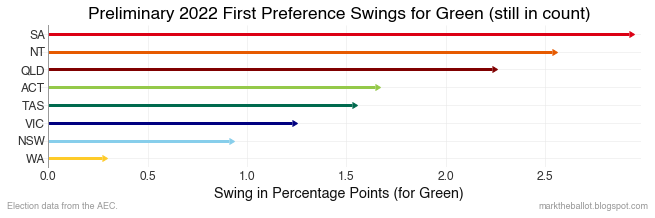

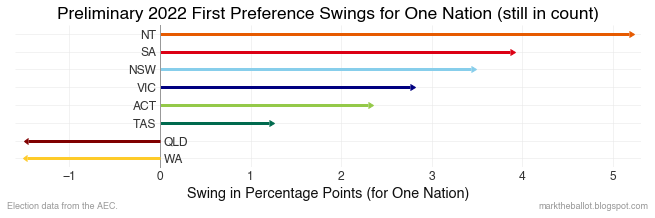

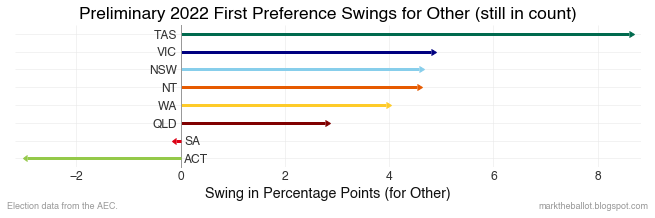

In [41]:
state_palette = {
    # colours from the R strayr package
    "NSW": '#87ceeb',
    "VIC": '#000080', 
    "QLD": '#800000', 
    "WA": '#fecb29', 
    "SA": '#dc0014', 
    "TAS": '#006a4e', 
    "ACT": '#94c949', 
    "NT": '#e65a00',
}

for group, dict_ in combined.items():
    
    # data
    series = pd.Series(dict_)
    
    # plot
    ax, rightax, data, labels = set_up_swing_chart(series)
    ax.figure.set_size_inches(9, 3)
    
    for x, y, l in zip(data, data.index, labels):
        ecolor = state_palette[l]
        if x >= 0:
            ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=ecolor)
        else:
            rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=ecolor)

    finalise_swing_chart(ax, rightax, data, labels)
    
    common.plot_finalise(
        ax, 
        title=f'Preliminary 2022 First Preference Swings for {group} (still in count)',
        ylabel=None,
        xlabel=f'Swing in Percentage Points (for {group})', 
        lfooter='Election data from the AEC.', 
    )        


### Divisional 2pp swings

In [42]:
houseTppByDivision

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
Adelaide (SA),Adelaide,179,SA,NaN,33009,37.90,54092,62.10,87101,-3.92,130151,66.923036
Aston (VIC),Aston,197,VIC,NaN,43469,53.16,38303,46.84,81772,-6.97,109826,74.455958
Ballarat (VIC),Ballarat,198,VIC,NaN,28907,36.96,49303,63.04,78210,-2.81,110704,70.647854
Banks (NSW),Banks,103,NSW,NaN,44211,53.74,38053,46.26,82264,-2.52,107786,76.321600
Barker (SA),Barker,180,SA,NaN,59312,65.24,31601,34.76,90913,-3.70,123518,73.603038
...,...,...,...,...,...,...,...,...,...,...,...,...
Werriwa (NSW),Werriwa,153,NSW,NaN,37464,44.80,46168,55.20,83632,0.27,126141,66.300410
Whitlam (NSW),Whitlam,150,NSW,NaN,40170,39.93,60423,60.07,100593,0.84,125535,80.131437
Wide Bay (QLD),Wide Bay,178,QLD,NaN,49845,61.53,31162,38.47,81007,-1.62,115420,70.184543
Wills (VIC),Wills,234,VIC,NaN,0,0.00,0,0.00,0,-24.29,108500,0.000000


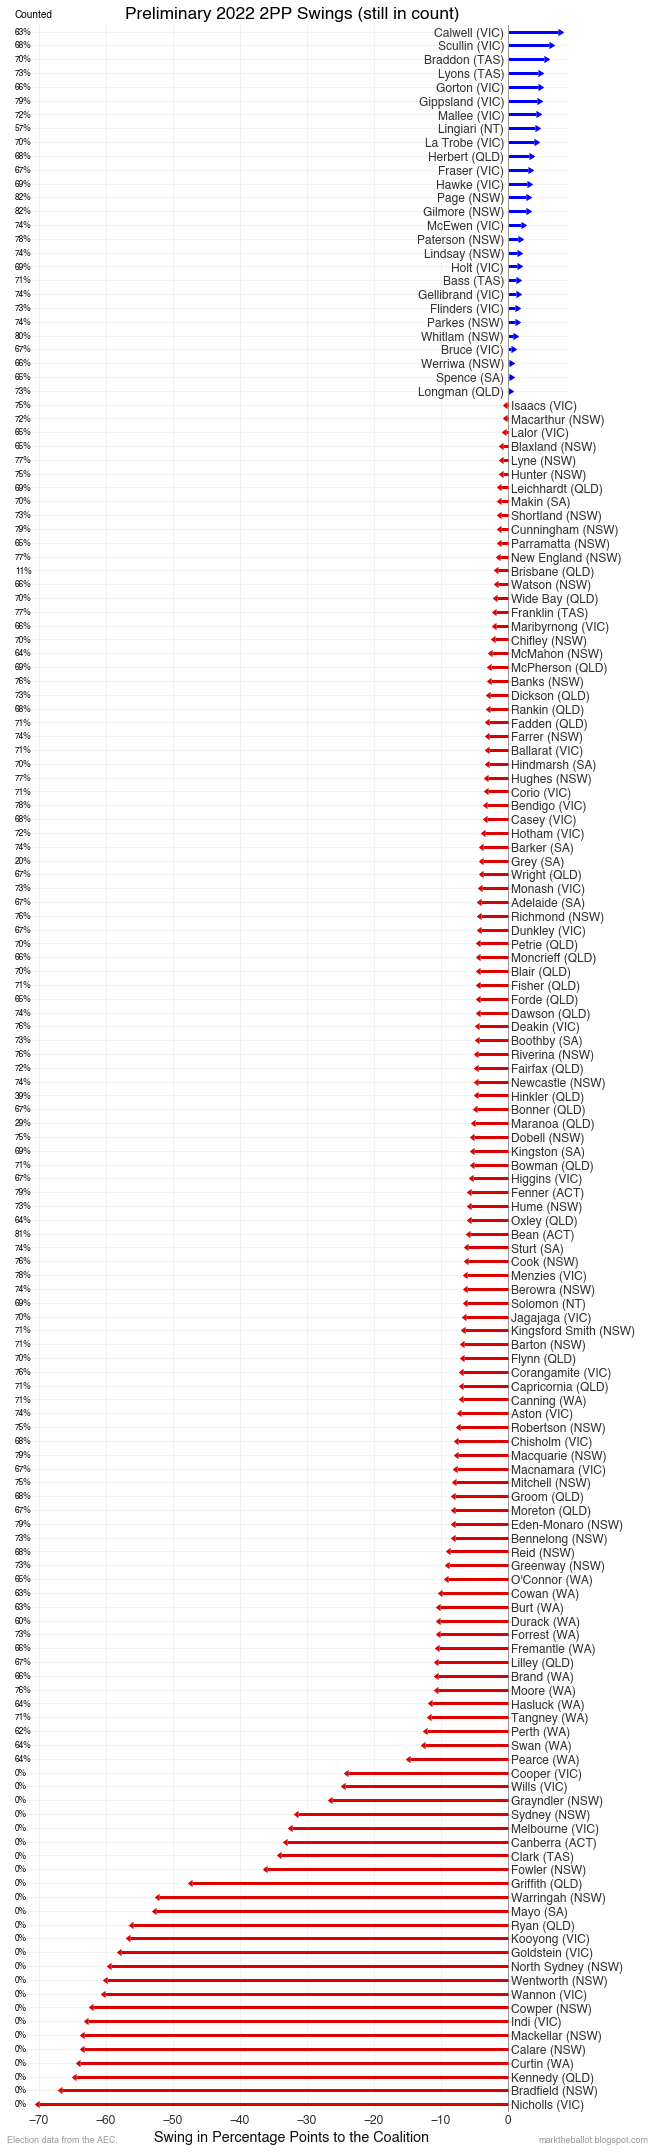

In [43]:
data = houseTppByDivision['Swing'].copy()
#data.index = [f'{a} {float(b):0.1f}' for a, b in zip(data.index, data)]
ax, rightax, data, labels = set_up_swing_chart(data)
ax.figure.set_size_inches(9, 30)
# plot our data
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')

finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{houseTppByDivision.at[label, "Counted%"]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

common.plot_finalise(
    ax, 
    title=f'Preliminary 2022 2PP Swings (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Coalition', 
    lfooter='Election data from the AEC. ', 
)    

### Green TCP swings

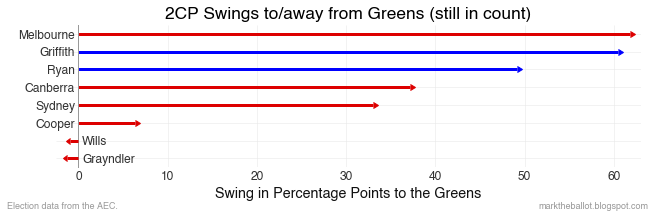

In [44]:
x_colors = {
    'ALP': '#dd0000',
    'Coalition': 'blue',
    'GRN': 'green',
    'IND': 'darkorange'
}

GREEN = 'GRN'
orig_ = tcp_swings[tcp_swings[GREEN].notna()]
greens = orig_[GREEN]

ax, rightax, series, labels = set_up_swing_chart(greens)
ax.figure.set_size_inches(9, 3)

# plot our data
for x, y, label in zip(series, series.index, labels):
    kommen = orig_.drop(GREEN, axis=1).loc[label].idxmax()
    c = x_colors[kommen]
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=c)
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=c)
        
finalise_swing_chart(ax, rightax, series, labels)

common.plot_finalise(
    ax, 
    title=f'2CP Swings to/away from Greens (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Greens', 
    lfooter='Election data from the AEC.', 
) 

### Traditional TCP swings

In [45]:
missing = tcp_swings.isna().all(axis=1)
missing_text = f'Missing from AEC feed: {(", ").join(missing[missing].index)}.' if missing.any() else ''
missing_text

''

In [46]:
TRADITIONAL = ['ALP', 'Coalition']
data = tcp_swings[tcp_swings[TRADITIONAL].notna().all(axis=1)]
data = data['Coalition']
data

DivisionNm
Adelaide   -3.92
Aston      -6.97
Ballarat   -2.81
Banks      -2.52
Barker     -3.70
            ... 
Watson     -1.46
Werriwa     0.27
Whitlam     0.84
Wide Bay   -1.62
Wright     -3.73
Name: Coalition, Length: 126, dtype: float64

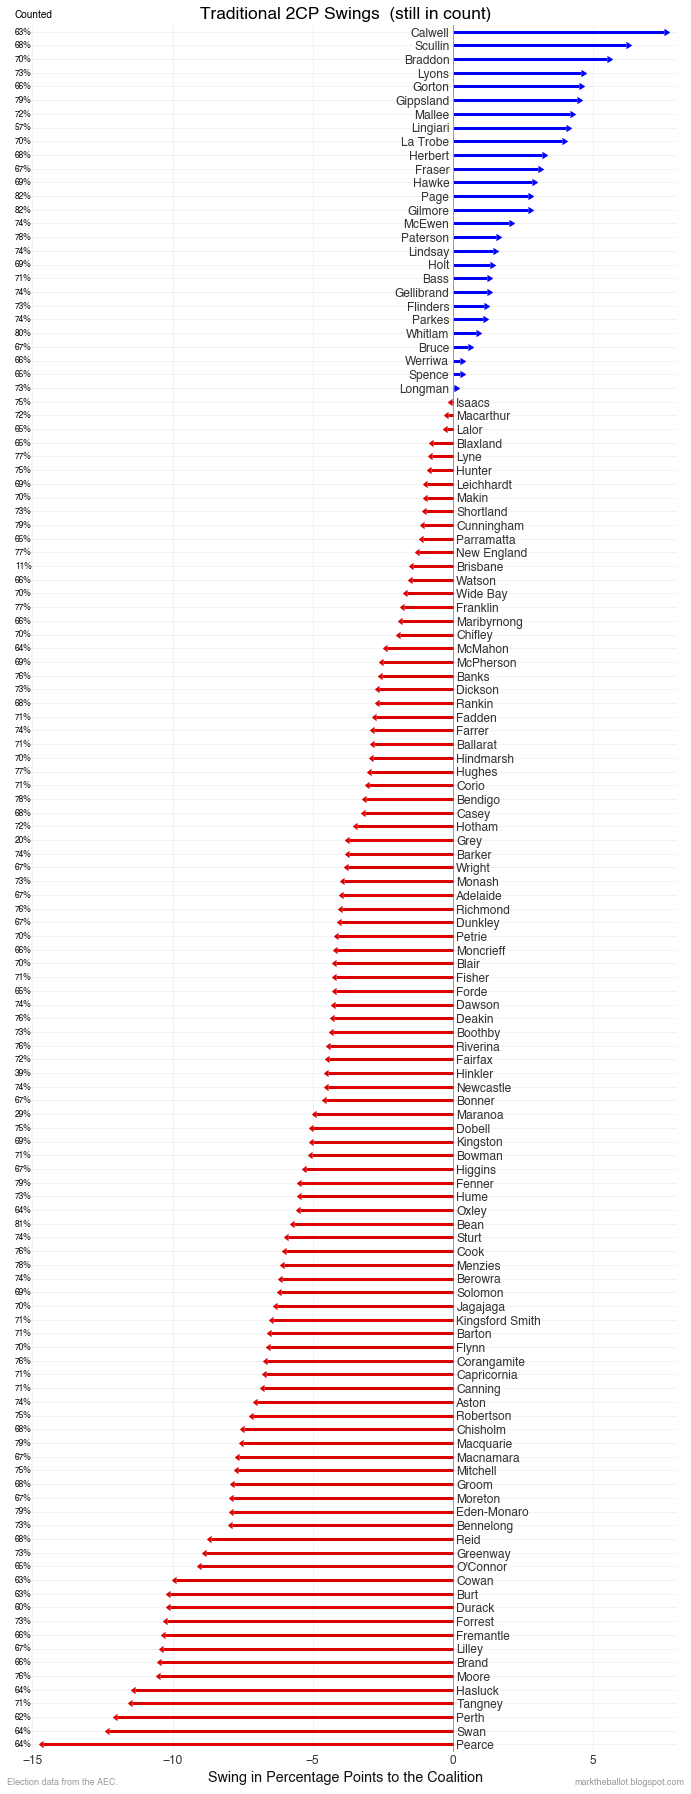

In [47]:
#data.index = [f'{a} {float(b):0.1f}' for a, b in zip(data.index, data)]
ax, rightax, data, labels = set_up_swing_chart(data)
ax.figure.set_size_inches(9.5, 25)
# plot our data
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')
        
finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{cooked_tcp_counted[label]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

common.plot_finalise(
    ax, 
    title=f'Traditional 2CP Swings  (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Coalition', 
    lfooter=f'Election data from the AEC. {missing_text}', 
)    

In [48]:
tcp_swings.loc['Brisbane']

PartyAb
ALP          1.41
GRN           NaN
IND           NaN
KAP           NaN
XEN           NaN
Coalition   -1.41
Name: Brisbane, dtype: float64

## Seat allocations

### Key thresholds

In [49]:
TCP_VOTE_THRESH = 51.5 # per cent
FP_VOTE_THRESH = 50
COUNT_THRESH = 50.0 # per cent
SA_COALITION = ['LP', 'LNP', 'NP', 'CLP']

### Functions

In [50]:
def move(bundle:Iterable, source:set, dest:set)-> None:
    moving = set(bundle).intersection(source)
    source.difference_update(moving)
    dest.update(moving)
    
def to_text(x:Iterable):
    return ', '.join(sorted(x))

In [51]:
def assign(vp_df, vc_series, vote_thresh, count_thresh, columns, source, dest):
    mask = (
        (vp_df[columns].sum(axis=1) > vote_thresh) 
        & (vc_series > count_thresh)
    )
    selected = mask[mask].index
    move(selected, source, dest)

### Baseline

In [52]:
unallocated, coalition, labor, cross_bench = set(fp_by_div.index), set(), set(), set()

### First preferences

In [53]:
# How many seats can we knock out on first preferences alone ...
x = (fp_vote_pct > FP_VOTE_THRESH).sum()
x[x > 0]

PartyAb
ALP    8
GRN    1
LNP    1
LP     4
NP     2
dtype: int64

In [54]:
assign(fp_vote_pct, fp_count_pct, FP_VOTE_THRESH, COUNT_THRESH, ['ALP'], unallocated, labor)
assign(fp_vote_pct, fp_count_pct, FP_VOTE_THRESH, COUNT_THRESH, ['GRN'], unallocated, cross_bench)
assign(fp_vote_pct, fp_count_pct, FP_VOTE_THRESH, COUNT_THRESH, ['KAP'], unallocated, cross_bench)
assign(fp_vote_pct, fp_count_pct, FP_VOTE_THRESH, COUNT_THRESH, ['IND'], unallocated, cross_bench)
assign(fp_vote_pct, fp_count_pct, FP_VOTE_THRESH, COUNT_THRESH, SA_COALITION, unallocated, coalition)

to_text(coalition), to_text(cross_bench), to_text(labor)

('Barker, Cook, Farrer, Gippsland, Maranoa, Mitchell, New England',
 'Melbourne',
 'Barton, Blaxland, Brand, Burt, Chifley, Grayndler, Sydney, Watson')

### TCP

In [55]:
cooked_pct_tcp_votes.columns

Index(['ALP', 'GRN', 'IND', 'KAP', 'XEN', 'Coalition'], dtype='object', name='PartyAb')

In [56]:
assign(cooked_pct_tcp_votes, cooked_tcp_counted, TCP_VOTE_THRESH, COUNT_THRESH, ['ALP'], unallocated, labor)
assign(cooked_pct_tcp_votes, cooked_tcp_counted, TCP_VOTE_THRESH, COUNT_THRESH, ['GRN'], unallocated, cross_bench)
assign(cooked_pct_tcp_votes, cooked_tcp_counted, TCP_VOTE_THRESH, COUNT_THRESH, ['IND'], unallocated, cross_bench)
assign(cooked_pct_tcp_votes, cooked_tcp_counted, TCP_VOTE_THRESH, COUNT_THRESH, ['KAP'], unallocated, cross_bench)
assign(cooked_pct_tcp_votes, cooked_tcp_counted, TCP_VOTE_THRESH, COUNT_THRESH, ['XEN'], unallocated, cross_bench)
assign(cooked_pct_tcp_votes, cooked_tcp_counted, TCP_VOTE_THRESH, COUNT_THRESH, ['Coalition'], unallocated, coalition)

to_text(labor), len(labor)

('Adelaide, Ballarat, Barton, Bean, Bendigo, Blair, Blaxland, Boothby, Brand, Bruce, Burt, Calwell, Canberra, Chifley, Chisholm, Cooper, Corangamite, Corio, Cowan, Cunningham, Dobell, Dunkley, Eden-Monaro, Fenner, Franklin, Fraser, Fremantle, Gellibrand, Gorton, Grayndler, Greenway, Hasluck, Hawke, Higgins, Hindmarsh, Holt, Hotham, Hunter, Isaacs, Jagajaga, Kingsford Smith, Kingston, Lalor, Lilley, Macarthur, Macnamara, Macquarie, Makin, Maribyrnong, McEwen, McMahon, Moreton, Newcastle, Oxley, Parramatta, Paterson, Pearce, Perth, Rankin, Reid, Richmond, Robertson, Scullin, Shortland, Solomon, Spence, Swan, Sydney, Tangney, Watson, Werriwa, Whitlam, Wills',
 73)

In [57]:
to_text(coalition), len(coalition)

("Aston, Banks, Barker, Bass, Berowra, Bonner, Bowman, Braddon, Canning, Capricornia, Cook, Cowper, Dawson, Dickson, Durack, Fadden, Fairfax, Farrer, Fisher, Flinders, Flynn, Forde, Forrest, Gippsland, Groom, Herbert, Hughes, Hume, La Trobe, Leichhardt, Lindsay, Longman, Lyne, Mallee, Maranoa, McPherson, Mitchell, Monash, Moncrieff, New England, Nicholls, O'Connor, Page, Parkes, Petrie, Riverina, Wide Bay, Wright",
 48)

In [58]:
to_text(cross_bench), len(cross_bench)

('Clark, Fowler, Goldstein, Indi, Kennedy, Kooyong, Mackellar, Mayo, Melbourne, North Sydney, Warringah, Wentworth',
 12)

In [59]:
to_text(unallocated), len(unallocated)

('Bennelong, Bradfield, Brisbane, Calare, Casey, Curtin, Deakin, Gilmore, Grey, Griffith, Hinkler, Lingiari, Lyons, Menzies, Moore, Ryan, Sturt, Wannon',
 18)

### House outcome and closer seats

In [60]:
def get_close(close, vote_thresh=TCP_VOTE_THRESH, count_thresh=COUNT_THRESH):
    close_tcp_votes = cooked_pct_tcp_votes.loc[close]
    max_value = close_tcp_votes.max(axis=1)
    max_label = close_tcp_votes.idxmax(axis=1)
    min_label = close_tcp_votes.idxmin(axis=1)
    return (
        pd.DataFrame({'Values': max_value.values, 
                      'Group': max_label.values, 
                      'Seat': close_tcp_votes.index },
                      index=[f'{seat} {a}-vs-{b}' 
                             for seat, a, b in zip(close_tcp_votes.index, max_label, min_label)],)
    ).sort_values('Values')


In [61]:
def plot_close(data:pd.DataFrame, title):
    
    fig, ax = common.initiate_plot()
    ax.figure.set_size_inches(9, 6)
    for x, y, c in zip(data['Values'], data.index, data['Group']):
        if math.isnan(x):
            x=50
        color = x_colors[c] if c in x_colors else 'white'
        ax.barh(y, x-50, left=50, color=color)

    # add in the count completion percentages for each division
    xlim_lo, xlim_high = ax.get_xlim()
    adj = (xlim_high - xlim_lo) * 0.025
    ax.set_xlim(xlim_lo, xlim_high+adj)
    for y, label in enumerate(data['Seat']):
        if math.isnan(x):
            continue
        text = f'{cooked_tcp_counted[label]:0.0f}%'
        ax.text(xlim_high+adj, y, text, ha='right', va='center', fontsize='small')
    ax.text(xlim_high+adj, y+1, 'Counted', ha='right', va='center', )

    common.plot_finalise(
        ax, 
        title=title,
        ylabel=None,
        xlabel='Per cent two-candidate-preferred vote share', 
        lfooter=f'Election data from the AEC.', 
    )

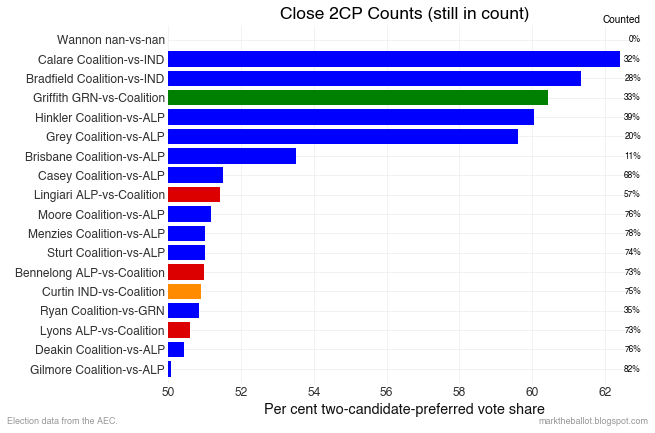

In [62]:
plot_close(get_close(list(unallocated)), title=f'Close 2CP Counts (still in count)')

In [63]:
# Let's look in detail at the problematics ...

for k in sorted(list(unallocated)):
    print(k)
    print('% Primary Counted:', fp_count_pct[k])
    print('First preferences:\n', fp_vote_pct.loc[k].dropna())
    print('% TCP Counted:', cooked_tcp_counted[k])
    print('TCP:\n', raw_pct_tcp_votes.loc[k].dropna())
    print('=' * 20)

Bennelong
% Primary Counted: 73.72511518734242
First preferences:
 PartyAb
ALP     38.16
DPDA     1.21
GRN     10.92
LDP      1.46
LP      41.65
ON       1.61
SOPA     2.03
UAPP     2.95
Name: Bennelong, dtype: float64
% TCP Counted: 73.08615143875511
TCP:
 PartyAb
ALP    50.970013
LP     49.029987
Name: Bennelong, dtype: float64
Bradfield
% Primary Counted: 73.14802022602305
First preferences:
 PartyAb
ALP     17.00
GRN      8.85
IND     24.89
LP      45.08
ON       1.58
UAPP     2.60
Name: Bradfield, dtype: float64
% TCP Counted: 28.249196393210095
TCP:
 PartyAb
IND    38.658668
LP     61.341332
Name: Bradfield, dtype: float64
Brisbane
% Primary Counted: 67.78690684360554
First preferences:
 PartyAb
AJP      1.75
ALP     27.65
GRN     27.03
LDP      1.53
LNP     38.15
ON       2.03
UAPP     1.85
Name: Brisbane, dtype: float64
% TCP Counted: 10.872637554794357
TCP:
 PartyAb
ALP    46.48601
LNP    53.51399
Name: Brisbane, dtype: float64
Calare
% Primary Counted: 83.05501628771675
First

## The End

In [64]:
print('Done')

Done
